In [1]:
#----------------------
#
#Szki programu na podstawie
#doi:10.1371/journal.pone.0033501
#
#napisany około 15.02.2024
#
#----------------------

import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random

## Definitions of functions

In [2]:
# 1>=f>=0
def h(f):
    """
    Parameter used to define double well potential and volume element
    takes field matrix as argument it
    """
    return f*f*(3-2*f)

# bezpośrednio związane z warunkami brzegowymi (tutaj - sferyczne)
def laplacian(f):
    """
    discretized laplacian for a grid with arbitrary spacings
    takes field matrix as argument
    """
    L = (np.roll(f,-1,axis=0)+np.roll(f,1,axis=0)-2*f)/(dx*dx)
    L += (np.roll(f,-1,axis=1)+np.roll(f,1,axis=1)-2*f)/(dy*dy)
    return L

def kdelta(i,j):
    """
    kronecker delta
    arguments are two real numbers
    """
    if i==j:
        return 1
    return 0

#wprowadzanie dużego wektora macierzy do każdej funkcji jako argumentu jest bardzo niepraktyczne i podczas dopracowywania kodu trzeba będzie zmienić ten sposób deklaracji funkcji
def volume(u,i,m):
    """
    calculates volume of a particular field

    u - vector of vectors of fields with values from 0 to 1
    i - field (cell) type
    m - field (cell) number
    """
    return np.sum(h(u[i][m]))*dx*dy

def phi_calc(u,i):
    """
    summs fields of the same type

    u - vector of vectors of fields with values from 0 to 1
    i - field (cell) type
    """
    result = np.zeros((Nx,Ny))
    for uim in u[i]:
        result += uim
    return result

def sum_u(u,i):
    """
    summs volume elements for fields of the same type

    u - vector of vectors of fields with values from 0 to 1
    i - field (cell) type
    """
    result = np.zeros((Nx,Ny))
    for uim in u[i]:
        result += h(uim)
    return result

def generate_cell(xcenter, ycenter, radius=0.5, smoothness=1):
    """
    generates a field with values from 0 to 1 and given position, radius and smoothness (width of hiperbolic tangent function acting as a cell wall)

    xcenter - first position component
    ycenter - second position component
    radius - circular field (cell) radius
    smoothness - higher value corresponds to steeper field wall
    """
    matrix = np.zeros((Nx, Ny))
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    return -np.tanh(smoothness * (np.sqrt((xv-xcenter)**2 + (yv-ycenter)**2) - radius))/2 + 1/2

def take_position(u,i,m):
    """
    gives position for COM of given field (cell)

    u - vector of vectors of fields with values from 0 to 1
    i - field (cell) type
    m - field (cell) number
    """
    Nx, Ny = u[i][m].shape
    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)

    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)

    X, Y = np.meshgrid(x, y, indexing='ij')

    total_mass = np.sum(u[i][m])
    com_x = np.sum(X * u[i][m]) / total_mass
    com_y = np.sum(Y * u[i][m]) / total_mass

    return com_x, com_y

def cell_divide(u,i,m,volLim,smoothness):
    """
    divides cell into two after reaching field volume limit (volume limit should be lower than maximal volume of a cell!)

    u - vector of vectors of fields with values from 0 to 1
    i - field (cell) type
    m - field (cell) number
    volLim - volume limit for cell division
    smoothness - higher value corresponds to steeper field wall
    """
    volu = volume(u,i,m)
    if volu<volLim:
        return
    else:
        new_radius = np.sqrt(volu/np.pi/2)
        theta = random.uniform(0, 2*np.pi)
        omega_x, omega_y = np.cos(theta), np.sin(theta)
        com_x, com_y = take_position(u,i,m)
        com = com_x, com_y
        # poniższy meshgrid jest w tej samej postaci wykorzystywany podczas liczenia środka masy
        matrix = np.zeros((Nx, Ny))
        x = np.linspace(0, Lx, Nx)
        y = np.linspace(0, Ly, Ny)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        new_u_1 = (np.tanh(smoothness * (omega_x*(xv-com_x)+omega_y*(yv-com_y))) + 1)*u[i][m]/2
        new_u_2 = (-np.tanh(smoothness * (omega_x*(xv-com_x)+omega_y*(yv-com_y))) + 1)*u[i][m]/2
         
        u[i][m]=new_u_1
        u[i].append(new_u_2)

## Definition of differential equation

In [3]:
def gs(u, i, m, s):
    return eta[i]*u[i][m]*(1-u[i][m])*laplacian(h(s))

def gint(u, i, m, phi):
    result = eta[i][i]*u[i][m]*(1-u[i][m])*laplacian(phi[i]-h(u[i][m])*kdelta(i,i))
    return result + gamma[i]*u[i][m]*(1-u[i][m])*laplacian(h(u[i][m]))

def f_term(u, i, m, s, phi):
    result = alpha[i]*(V_max[i]-volume(u,i,m))
    result += -beta[i][i]*(phi[i]-h(u[i][m])*kdelta(0,0))
    return result - beta_s[i]*h(s)

def time_differential_equation(u, i, m, s, phi):
    """
    RHS of time dependent differential equation du/dt = RHS, 

    u - vector of vectors of fields with values from 0 to 1
    i - field (cell) type
    m - field (cell) number
    s - external field (interaction definition should be implemented inside this function)
    phi - vector of summed u fields
    """
    result = D[i]*laplacian(u[i][m])
    result += u[i][m]*(1-u[i][m])*(u[i][m]-0.5+f_term(u,i,m,s,phi))
    result += gint(u,i,m,phi)
    result += gs(u,i,m,s)
    return result/tau_u

## Static parameters

In [4]:
#grid lengths in arbitrary units
Lx, Ly = 60, 60
#time step size
dt = 0.01
#spatial step sizes
dx = 0.05
dy = 0.05
#number of grid points
Nx, Ny = int(Lx/dx), int(Ly/dy)

#PDF parameters (used in time_differential_equation function)
tau_u = 1
#diffusion coefficient
D = [0.001]

#single cell interaction coefficients
eta_s = [0]
eta = [[0]]
#correction coefficient
gamma = [0]
#volume limiting coefficient
alpha = [1]
#cell type field interaction coefficients
beta_s = [0]
beta = [[1]]

#maximum volume
V_max = [1]

#number of cell types
L = 1

#cell smoothness
smoothness = 10

# Plotting functions

In [17]:
def plot_contour(Z, t, numOfCells):
    levels = [0.5]
    x = np.linspace(0, 60, Z.shape[0])
    y = np.linspace(0, 60, Z.shape[1])
    X, Y = np.meshgrid(x, y)
    
    plt.contour(Y, X, Z.T, levels, colors='black', linewidths=0.5)  # Transpose Z to match the meshgrid orientation
    plt.title(f"$timestep = {t}, num of cells = {numOfCells}$")
    plt.grid(True)

def plot_all(Z, i, t, numOfCells):
    for j in Z[i]:
        plot_contour(j, t, numOfCells)
    

def plot_value(Z, t, numOfCells):
    plt.imshow(Z, extent=(0, 60, 0, 60), cmap='copper')
    #plt.colorbar()
    plt.title(f"$timestep = {t}, num of cells = {numOfCells}$")

## Replication of fig. 4

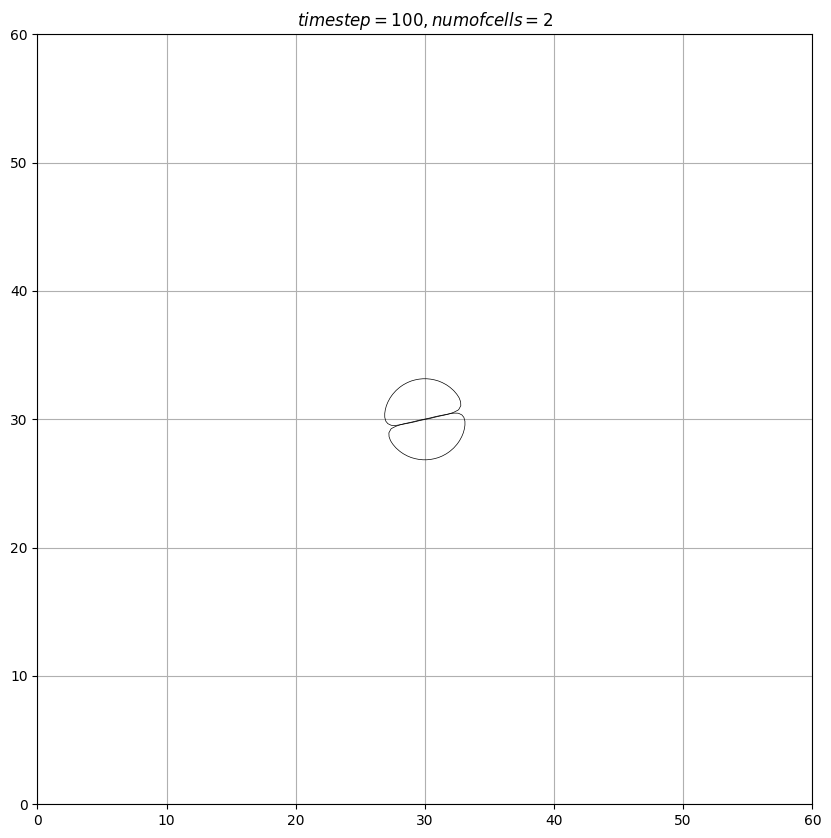

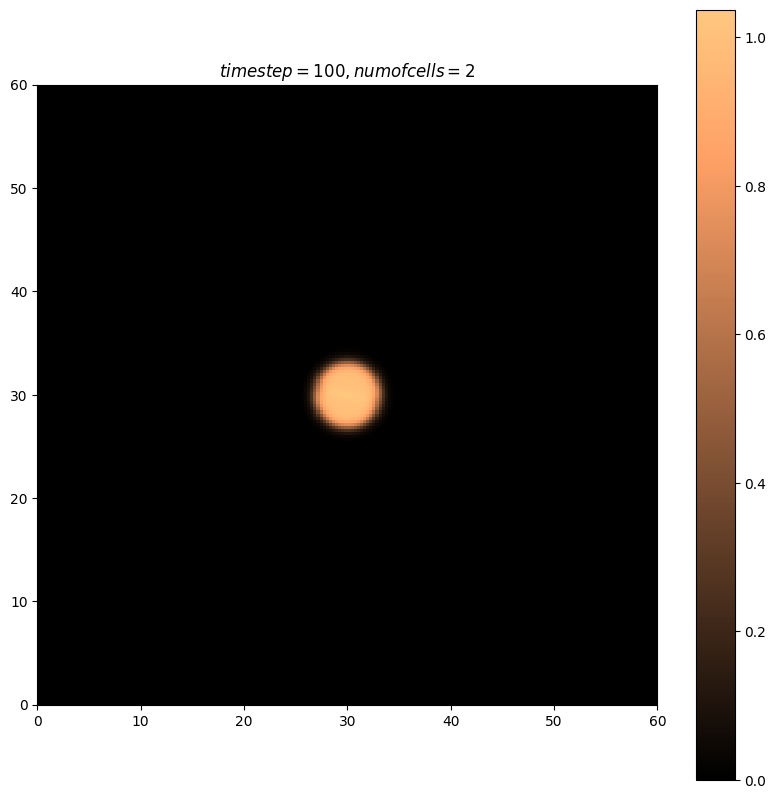

KeyboardInterrupt: 

In [18]:
Lx, Ly = 10, 10
dt = 0.1
dx = 0.05
dy = 0.05
Nx, Ny = int(Lx/dx), int(Ly/dy)

# parametry typów komórek

tau_u = 1
D = [0.001]

eta_s = [0]
eta = [[0]]
gamma = [0]
alpha = [1]
beta = [[1]]
beta_s = [0]

V_max = [1]


L = 1



smoothness = 10

u = [[generate_cell(5,5,0.5,smoothness)]]
phi_arr = [sum_u(u,0)]

s = np.zeros((Nx,Ny))

#plt.figure(figsize=(10, 10))
#plot_all(u,0,0,2)
#plt.show()

dt = 0.01
for t in range(10000):
    numOfCells = len(u[0])
    for n in range(numOfCells):
        phi_arr = [sum_u(u,0)]
        u[0][n] += dt * time_differential_equation(u, 0, n, s, phi_arr)
        cell_divide(u,0,n,0.7,smoothness)
    if t==100:
        plt.figure(figsize=(10, 10))
        plot_all(u,0,t,len(u[0]))
        plt.show()
        plt.figure(figsize=(10, 10))
        plot_value(phi_calc(u,0),t,len(u[0]))
        plt.colorbar()
        plt.show()

plt.figure(figsize=(10, 10))
plot_all(u,0,t,len(u[0]))
plt.show()
plt.figure(figsize=(10, 10))
plot_value(phi_calc(u,0),t,len(u[0]))
plt.colorbar()
plt.show()

In [16]:
len(u)

1